In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

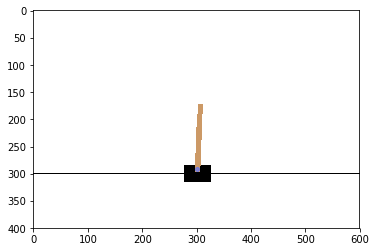

In [3]:
# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
n_observation = env.observation_space.shape[0]
plt.imshow(env.render("rgb_array"))

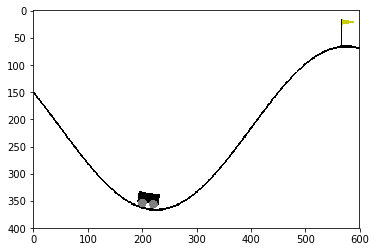

In [3]:
# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("MountainCar-v0").env

env.reset()
n_actions = env.action_space.n
n_observation = env.observation_space.shape[0]
plt.imshow(env.render("rgb_array"))

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class MLP(nn.Module):
    def __init__(self, D_in, D_out):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(D_in, 128),
            nn.ReLU(),
            nn.Linear(128, 52),
            nn.ReLU(),
            nn.Linear(52, D_out)
        ).to(device)
        self.logprob = nn.Softmax(dim=1).to(device)
        
    def forward(self, x):
        y = self.layers(x)
        y = self.logprob(y)
        return y

In [6]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-1000, 200], save=False, name="temp.png"):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    if save:
        plt.savefig(name, dpi=600)
    plt.show()

In [25]:
def generate_session(t_max=10000):

    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):

        # predict array of action probabilities
        probs = agent(Variable(torch.FloatTensor([s]).to(device), volatile=True))[0].detach().cpu().numpy()

        a = np.random.choice(n_actions, p=probs)
        
        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        # make own reward        
#         total_reward += r
        max_pos = 0.6
        min_pos = -1.2
        max_vel = 0.07
        min_vel = -0.07
#         if new_s[0] < -0.2:
#             total_reward -= 1
#         else:
        total_reward += r + ((new_s[0] + np.abs(max_pos + min_pos)/2)/ (max_pos+np.abs(max_pos + min_pos)/2))**2
#         total_reward += r
#         total_reward += -1 if new_s[0]>0.3 else 1
            

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [26]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """

    
    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = [s for i, s in enumerate(states_batch) if rewards_batch[i] >= reward_threshold]
    elite_actions = [a for i, a in enumerate(actions_batch) if rewards_batch[i] >= reward_threshold]

#     elite_states = states_batch[rewards_batch>reward_threshold]
#     elite_actions = actions_batch[rewards_batch>reward_threshold]
    
    return elite_states, elite_actions

mean reward = -7802.638, threshold=-8029.835


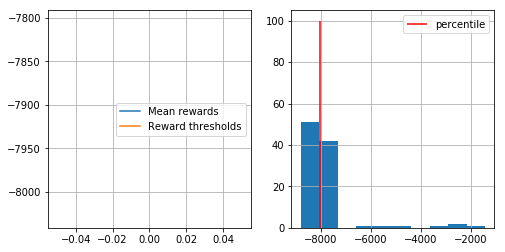

In [ ]:
n_sessions = 100
percentile = 55
learning_rate = 0.01
log = []

agent = MLP(n_observation, n_actions)
optimizer = optim.Adam(agent.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

for i in range(200):
    # generate new sessions
    sessions = [ generate_session()  for _ in range(n_sessions) ]
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)
    elite_states, elite_actions  = map(np.concatenate, [elite_states, elite_actions])
    
    pred = agent.forward(Variable(torch.FloatTensor(elite_states).to(device), volatile=True))
    loss = criterion(pred, torch.tensor(elite_actions).to(device))
    
    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])
    if np.mean(rewards_batch) > 900:
        print("You Win! You may stop training now via KeyboardInterrupt.")

In [ ]:
show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)], save=True, name="MLP_32_relu_32_relu_p70t")
    

### Results

In [102]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("MountainCar-v0"),
                           directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()


/home/tdtce/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()
/home/tdtce/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


KeyboardInterrupt: 

In [322]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices